# Counterfactuals benchmark on tabular datasets

In [1]:
import tensorflow as tf
import os
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_eager_execution()


BASE_PATH = "./counterfactuals"
print("Current working directory:", os.getcwd())


2025-07-07 13:22:29.923684: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 13:22:29.961424: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-07 13:22:29.961452: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-07 13:22:29.961483: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-07 13:22:29.970513: I tensorflow/core/platform/cpu_feature_g

Current working directory: /home/ahmed/prototype


## Imports and preprocessing

In [12]:
# Install the dev version of the Alibi package if not already installed
try:
    from alibi import __version__ as alibi_version
    print(f"Alibi version: {alibi_version}")
except ImportError:
    print("Alibi package not found, installing...")
    # Install the dev version of Alibi
    !pip install git+https://github.com/SeldonIO/alibi.git > /dev/null


import logging

alibi_logger = logging.getLogger("alibi")
alibi_logger.setLevel("CRITICAL")


print(f"Is TensorFlow running in eager execution mode? -----→ {tf.executing_eagerly()}")
!nvidia-smi -L

Alibi version: 0.9.7.dev0
Is TensorFlow running in eager execution mode? -----→ True
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU (UUID: GPU-ed7340f2-1910-df12-4a83-29feeba52695)


In [3]:
from datetime import datetime

if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)


date = datetime.now().strftime('%Y-%m-%d')
EXPERIMENT_PATH = f"{BASE_PATH}/diabetes_{date}"
MODELS_EXPERIMENT_PATH = f"{BASE_PATH}/diabetes_2020-09-09"
if not os.path.exists(EXPERIMENT_PATH):
    os.makedirs(EXPERIMENT_PATH)
    


## Data import and preprocessing

In [4]:
import json
# import pickle
# import time
# from matplotlib import offsetbox
# from matplotlib.colors import ListedColormap
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import Dense, Add, Input, ActivityRegularization, Concatenate, Multiply
from tensorflow.keras import optimizers, Model, regularizers, Input

from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

from tensorflow.keras import backend as K
# from tensorflow.keras.models import load_model
import os
import time

print("Current working directory:", os.getcwd())

INITIAL_CLASS = 0
DESIRED_CLASS = 1
N_CLASSES = 2
n_training_iterations = 10


np.set_printoptions(precision=2)
set_seed(2020)
np.random.seed(2020)

# German Credit dataset

def preprocess_data_german(df, target_column="Outcome"):
    """
    Preprocess the German Credit dataset by encoding categorical variables and splitting the data into 
    train, test, and user simulation sets.
    
    Returns a dictionary with processed train, test, and user datasets.
    """
    
    # Assign meaningful column names
    df.columns = [
        'Status', 'Month', 'Credit_History', 'Purpose', 'Credit_Amount',
        'Savings', 'Employment', 'Installment_Rate', 'Personal_Status', 'Other_Debtors',
        'Residence_Duration', 'Property', 'Age', 'Other_Installment_Plans', 'Housing',
        'Existing_Credits', 'Job', 'Num_Liable_People', 'Telephone', 'Foreign_Worker',
        'Outcome'
    ]
    
    # Mapping categorical features to more meaningful values
    status_mapping = { 'A11': '< 0 DM', 'A12': '0 <= ... < 200 DM', 'A13': '>= 200 DM / salary assignments for at least 1 year', 'A14': 'no checking account' }
    credit_history_mapping = { 'A30': 'no credits taken/ all credits paid back duly', 'A31': 'all credits at this bank paid back duly', 'A32': 'existing credits paid back duly till now', 'A33': 'delay in paying off in the past', 'A34': 'critical account/other credits existing' }
    savings_mapping = { 'A61': '< 100 DM', 'A62': '100 <= ... < 500 DM', 'A63': '500 <= ... < 1000 DM', 'A64': '>= 1000 DM', 'A65': 'unknown/no savings account' }
    employment_mapping = { 'A71': 'unemployed', 'A72': '< 1 year', 'A73': '1 <= ... < 4 years', 'A74': '4 <= ... < 7 years', 'A75': '>= 7 years' }
    personal_status_mapping = { 'A91': 'male: divorced/separated', 'A92': 'female: divorced/separated/married', 'A93': 'male: single', 'A94': 'male: married/widowed', 'A95': 'female: single' }
    other_debtors_mapping = { 'A101': 'none', 'A102': 'co-applicant', 'A103': 'guarantor' }
    property_mapping = { 'A121': 'real estate', 'A122': 'building society savings agreement/life insurance', 'A123': 'car or other, not in attribute 6', 'A124': 'unknown/no property' }
    other_installment_plans_mapping = { 'A141': 'bank', 'A142': 'stores', 'A143': 'none' }
    housing_mapping = { 'A151': 'rent', 'A152': 'own', 'A153': 'for free' }
    telephone_mapping = { 'A191': 'none', 'A192': 'yes, registered under the customer\'s name' }
    foreign_worker_mapping = { 'A201': 'yes', 'A202': 'no' }

    # Apply mappings
    df['Status'] = df['Status'].map(status_mapping)
    df['Credit_History'] = df['Credit_History'].map(credit_history_mapping)
    df['Savings'] = df['Savings'].map(savings_mapping)
    df['Employment'] = df['Employment'].map(employment_mapping)
    df['Personal_Status'] = df['Personal_Status'].map(personal_status_mapping)
    df['Other_Debtors'] = df['Other_Debtors'].map(other_debtors_mapping)
    df['Property'] = df['Property'].map(property_mapping)
    df['Other_Installment_Plans'] = df['Other_Installment_Plans'].map(other_installment_plans_mapping)
    df['Housing'] = df['Housing'].map(housing_mapping)
    df['Telephone'] = df['Telephone'].map(telephone_mapping)
    df['Foreign_Worker'] = df['Foreign_Worker'].map(foreign_worker_mapping)

    # Encode ordinal columns
    ordinal_cols = ['Status', 'Credit_History', 'Savings', 'Employment']
    le = LabelEncoder()
    for col in ordinal_cols:
        df[col] = le.fit_transform(df[col])

    # One-hot encode nominal columns
    nominal_columns = ['Purpose', 'Personal_Status', 'Other_Debtors', 'Property', 
                       'Other_Installment_Plans', 'Housing', 'Job', 'Telephone', 'Foreign_Worker']
    df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)

    # Process target variable
    Y = df[target_column].replace(1, 0).replace(2, 1)
    X = df.drop(columns=[target_column])

    # Get final feature set
    # list all features
    immutable_features = set(X.columns) - set(['Status', 'Credit_History'])
    

    mutable_features = set(X.columns) - set(immutable_features)
    mutable_features = list(mutable_features)

    features = list(mutable_features) + list(immutable_features)

    return  X, Y, features, immutable_features, mutable_features
    
# =========================================================


# Make sure 'german.csv' is in your project directory
df = pd.read_csv('statlog_german_credit_data/german.data', sep=' ', skiprows=1, header=None)
x,y, features, immutable_features, mutable_features = preprocess_data_german(df)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2020)

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



Current working directory: /home/ahmed/prototype


In [5]:
def compute_reconstruction_error(x, autoencoder):
    """Compute the reconstruction error for a given autoencoder and data points."""
    preds = autoencoder.predict(x)
    preds_flat = preds.reshape((preds.shape[0], -1))
    x_flat = x.reshape((x.shape[0], -1))
    return np.linalg.norm(x_flat - preds_flat, axis=1)

def format_metric(metric):
    """Return a formatted version of a metric, with the confidence interval."""
    return f"{metric.mean():.3f} ± {1.96*metric.std()/np.sqrt(len(metric)):.3f}"

def compute_metrics(samples, counterfactuals, latencies, classifier, autoencoder,
                    batch_latency=None):
    """ Summarize the relevant metrics in a dictionary. """
    reconstruction_error = compute_reconstruction_error(counterfactuals, autoencoder)
    delta = np.abs(samples-counterfactuals)
    l1_distances = delta.reshape(delta.shape[0], -1).sum(axis=1)
    prediction_gain = (
        classifier.predict(counterfactuals)[:, DESIRED_CLASS] - 
        classifier.predict(samples)[:, DESIRED_CLASS]
    )

    metrics = dict()
    metrics["reconstruction_error"] = format_metric(reconstruction_error)
    metrics["prediction_gain"] = format_metric(prediction_gain)
    metrics["sparsity"] = format_metric(l1_distances)
    metrics["latency"] = format_metric(latencies)
    batch_latency = batch_latency if batch_latency else sum(latencies)
    metrics["latency_batch"] = f"{batch_latency:.3f}"

    return metrics

def save_experiment(method_name, samples, counterfactuals, latencies, 
                    batch_latency=None):
    """Create an experiment folder and save counterfactuals, latencies and metrics."""
    if not os.path.exists(f"{EXPERIMENT_PATH}/{method_name}"):
        os.makedirs(f"{EXPERIMENT_PATH}/{method_name}")   

    np.save(f"{EXPERIMENT_PATH}/{method_name}/counterfactuals.npy", counterfactuals)
    np.save(f"{EXPERIMENT_PATH}/{method_name}/latencies.npy", latencies)

    metrics = compute_metrics(samples, counterfactuals, latencies, classifier, autoencoder)
    json.dump(metrics, open(f"{EXPERIMENT_PATH}/{method_name}/metrics.json", "w"))
    pprint(metrics)

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Add, Input, ActivityRegularization
from tensorflow.keras import Model, optimizers, regularizers
from tensorflow.keras.utils import to_categorical

tf.random.set_seed(2020)
np.random.seed(2020)



# Load the classifier model
filename = f"{EXPERIMENT_PATH}/classifier.keras"
classifier = load_model(filename)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Classifier loaded from {filename}") 

2025-07-07 13:22:48.707631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Classifier loaded from ./counterfactuals/diabetes_2025-07-07/classifier.keras


2025-07-07 13:22:48.769348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-07 13:22:48.769403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-07 13:22:48.770491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-07 13:22:48.770544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-07 13:22:48.770586: I tensorflow/compile

## Estimate density with the reconstruction error of a (denoising) autoencoder


In [7]:
# Load the autoencoder model
filename = f"{EXPERIMENT_PATH}/autoencoder.keras" 
autoencoder = load_model(filename)
# Ensure the autoencoder is compiled with the same optimizer and loss function  
autoencoder.compile(optimizer='nadam', loss='mse')

print(f"Autoencoder loaded from {filename}")

Autoencoder loaded from ./counterfactuals/diabetes_2025-07-07/autoencoder.keras


## GAN-based counterfactual search

In [8]:
def generate_fake_samples(x, generator):
    """Use the input generator to generate samples."""
    return generator.predict(x)

def data_stream(x, y=None, batch_size=500):
    """Generate batches until exhaustion of the input data."""
    n_train = x.shape[0]
    if y is not None:
        assert n_train == len(y)
    n_complete_batches, leftover = divmod(n_train, batch_size)
    n_batches = n_complete_batches + bool(leftover)

    perm = np.random.permutation(n_train)
    for i in range(n_batches):
        batch_idx = perm[i * batch_size:(i + 1) * batch_size]
        if y is not None:
            output = (x[batch_idx], y[batch_idx])
        else:
            output = x[batch_idx]
        yield output


def infinite_data_stream(x, y=None, batch_size=500):
    """Infinite batch generator."""
    batches = data_stream(x, y, batch_size=batch_size)
    while True:
        try:
            yield next(batches)
        except StopIteration:
            batches = data_stream(x, y, batch_size=batch_size)
            yield next(batches)

def create_generator(in_shape=(X_train.shape[1],), residuals=True):
    """Define and compile the residual generator of the CounteRGAN."""
    generator_input = Input(shape=in_shape, name='generator_input')
    generator = Dense(64, activation='relu')(generator_input)
    generator = Dense(32, activation='relu')(generator)
    generator = Dense(64, activation='relu')(generator)
    generator = Dense(in_shape[0], activation='tanh')(generator)
    generator_output = ActivityRegularization(l1=0., l2=1e-6)(generator)
    
    if residuals:
        generator_output = Add(name="output")([generator_input, generator_output])

    return Model(inputs=generator_input, outputs=generator_output)


def create_discriminator(in_shape=(X_train.shape[1],)):
    """ Define a neural network binary classifier to classify real and generated 
    examples."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=in_shape),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ], name="discriminator")
    optimizer = optimizers.legacy.Adam(learning_rate=0.0005, beta_1=0.5, decay=1e-8)
    model.compile(optimizer, 'binary_crossentropy', ['accuracy'])
    return model


def define_countergan(generator, discriminator, classifier, 
                      input_shape=(X_train.shape[1],)):
    """Combine a generator, discriminator, and fixed classifier into the CounteRGAN."""
    discriminator.trainable = False
    classifier.trainable = False

    countergan_input = Input(shape=input_shape, name='countergan_input')
  
    x_generated = generator(countergan_input)

    countergan = Model(
        inputs=countergan_input, 
        outputs=[discriminator(x_generated), classifier(x_generated)]
    )
        
    optimizer = optimizers.legacy.RMSprop(learning_rate=2e-4, decay=1e-8)
    countergan.compile(optimizer, ["binary_crossentropy", "categorical_crossentropy"])
    return countergan


def define_weighted_countergan(generator, discriminator, 
                               input_shape=(X_train.shape[1],)):
    """Combine a generator and a discriminator for the weighted version of the 
    CounteRGAN."""
    discriminator.trainable = False
    classifier.trainable = False
    countergan_input = Input(shape=input_shape, name='countergan_input')
  
    x_generated = generator(countergan_input)

    countergan = Model(inputs=countergan_input, outputs=discriminator(x_generated))
    optimizer = optimizers.legacy.RMSprop(learning_rate=5e-4, decay=1e-8)
    countergan.compile(optimizer, "binary_crossentropy")  
    return countergan



In [9]:
def train_countergan(n_discriminator_steps, n_generator_steps, n_training_iterations,
                     classifier, discriminator, generator, batches, 
                     weighted_version=False):
    """ Main function: train the CounteRGAN"""
    def check_divergence(x_generated):
        return np.all(np.isnan(x_generated))

    def print_training_information(generator, classifier, X_test, iteration):
        X_gen = generator.predict(X_test)
        clf_pred_test = classifier.predict(X_test)
        clf_pred = classifier.predict(X_gen)

        delta_clf_pred = (clf_pred - clf_pred_test)[:, DESIRED_CLASS]
        y_target = to_categorical([DESIRED_CLASS] * len(clf_pred), 
                                  num_classes=N_CLASSES)
        print('='*88)
        print(f"Training iteration {iteration} at {datetime.now()}")
        
        
        reconstruction_error = np.mean(compute_reconstruction_error(X_gen, autoencoder))
        print(f"Autoencoder reconstruction error (infinity to 0): {reconstruction_error:.3f}")
        print(f"Counterfactual prediction gain (0 to 1): {delta_clf_pred.mean():.3f}")
        print(f"Sparsity (L1, infinity to 0): {np.mean(np.abs(X_gen-X_test)):.3f}")

    if weighted_version:
        countergan = define_weighted_countergan(generator, discriminator)
    else:
        countergan = define_countergan(generator, discriminator, classifier)

    for iteration in range(n_training_iterations):
        if iteration > 0:
            x_generated = generator.predict(x_fake_input)
            if check_divergence(x_generated):
                print("Training diverged with the following loss functions:")
                print(discrim_loss_1, discrim_accuracy, gan_loss, 
                    discrim_loss, discrim_loss_2, clf_loss)
                break

        # Periodically print and plot training information 
        if (iteration % 1000 == 0) or (iteration == n_training_iterations - 1):
            print_training_information(generator, classifier, X_test, iteration)

        # Train the discriminator
        discriminator.trainable = True
        for _ in range(n_discriminator_steps):
            x_fake_input, _ = next(batches)
            x_fake = generate_fake_samples(x_fake_input, generator)
            x_real = x_fake_input

            x_batch = np.concatenate([x_real, x_fake])
            y_batch = np.concatenate([np.ones(len(x_real)), np.zeros(len(x_fake))])
            
            # Shuffle real and fake examples
            p = np.random.permutation(len(y_batch))
            x_batch, y_batch = x_batch[p], y_batch[p]

            if weighted_version:
                classifier_scores = classifier.predict(x_batch)[:, DESIRED_CLASS]
                
                # The following update to the classifier scores is needed to have the 
                # same order of magnitude between real and generated samples losses
                real_samples = np.where(y_batch == 1.)
                average_score_real_samples = np.mean(classifier_scores[real_samples])
                classifier_scores[real_samples] /= average_score_real_samples
                
                fake_samples = np.where(y_batch == 0.)
                classifier_scores[fake_samples] = 1.

                discriminator.train_on_batch(
                    x_batch, y_batch, sample_weight=classifier_scores
                )
            else:
                discriminator.train_on_batch(x_batch, y_batch)

        # Train the generator 
        discriminator.trainable = False
        for _ in range(n_generator_steps):
            x_fake_input, _ = next(batches)
            y_fake = np.ones(len(x_fake_input))
            if weighted_version:
                countergan.train_on_batch(x_fake_input, y_fake)
            else:
                y_target = to_categorical([DESIRED_CLASS] * len(x_fake_input), 
                                          num_classes=N_CLASSES)
                countergan.train_on_batch(x_fake_input, [y_fake, y_target])
    return countergan

## CounteRGAN: first formulation for differentiable classifiers

In [10]:
# discriminator = create_discriminator()
# generator = create_generator(residuals=True)
# batches = infinite_data_stream(X_train, y_train, batch_size=256)
# samples = X_test 

# countergan = train_countergan(2, 4, 2000, classifier, discriminator, generator, batches)

# t_initial = time.time()
# counterfactuals = generator.predict(X_test)
# batch_latency = 1000*(time.time() - t_initial)

# latencies = np.zeros(len(X_test))
# for i, x in enumerate(X_test):
#     t_initial = time.time()
#     _ = generator.predict(np.expand_dims(x, axis=0))
#     latencies[i] = 1000*(time.time() - t_initial)

# print("-"*80)
# print("Metrics before immutable features projection:")
# pprint(compute_metrics(samples, counterfactuals, latencies, classifier, autoencoder,
#                     batch_latency=None))
# print("-"*80)

# # Set immutable features to original values
# counterfactuals[:, len(mutable_features):] = samples[:, len(mutable_features):]

# print("Metrics after immutable features projection:")
# save_experiment(method_name, X_test, counterfactuals, latencies, batch_latency)

# generator.save(f"{EXPERIMENT_PATH}/{method_name}/generator.h5", save_format='h5')
# discriminator.save(f"{EXPERIMENT_PATH}/{method_name}/discriminator.h5", save_format='h5')
# countergan.save(f"{EXPERIMENT_PATH}/{method_name}/countergan.h5", save_format='h5')

# load generator, discriminator and countergan models to the experiment path
method_name = "countergan"

generator = load_model(f"{EXPERIMENT_PATH}/{method_name}/generator.h5")
discriminator = load_model(f"{EXPERIMENT_PATH}/{method_name}/discriminator.h5")
countergan = load_model(f"{EXPERIMENT_PATH}/{method_name}/countergan.h5")


Define Fine-Tuning Function

In [11]:
import json

# Final recommended cluster configuration from grid search results
final_cluster_config = [
    {
        "cluster_id": 0,
        "immutable_features": [],
        "cost_weights": {
            "Credit_Amount": 1.0,
            "Employment": 1.0,
            "Savings": 1.0,
            "Job": 0.6
        }
    },
    {
        "cluster_id": 1,
        "immutable_features": ["Age", "Foreign_Worker"],
        "cost_weights": {
            "Credit_Amount": 1.5,
            "Employment": 0.7,
            "Savings": 0.8,
            "Job": 0.6
        }
    },
    {
        "cluster_id": 2,
        "immutable_features": ["Age", "Housing", "Foreign_Worker"],
        "cost_weights": {
            "Credit_Amount": 1.5,
            "Employment": 0.7,
            "Savings": 0.8,
            "Job": 0.6
        }
    },
    {
        "cluster_id": 3,
        "immutable_features": [],
        "cost_weights": {
            "Credit_Amount": 1.0,
            "Employment": 0.7,
            "Savings": 0.8,
            "Job": 0.6
        }
    },
    {
        "cluster_id": 4,
        "immutable_features": ["Age", "Foreign_Worker", "Job"],
        "cost_weights": {
            "Credit_Amount": 1.0,
            "Employment": 0.7,
            "Savings": 0.8,
            "Job": 0.6
        }
    },
    {
        "cluster_id": 5,
        "immutable_features": ["Housing_own"],
        "cost_weights": {
            "Credit_Amount": 2.0,
            "Employment": 0.7,
            "Savings": 1.0,
            "Job": 1.5
        }
    },
    {
        "cluster_id": 6,
        "immutable_features": ["Age", "Housing", "Foreign_Worker", "Job"],
        "cost_weights": {
            "Credit_Amount": 1.5,
            "Employment": 0.7,
            "Savings": 0.8,
            "Job": 1.4
        }
    },
    {
        "cluster_id": 7,
        "immutable_features": [],
        "cost_weights": {
            "Credit_Amount": 1.5,
            "Employment": 1.5,
            "Savings": 0.8,
            "Job": 1.5
        }
    },
    {
        "cluster_id": 8,
        "immutable_features": ["Age", "Foreign_Worker", "Job"],
        "cost_weights": {
            "Credit_Amount": 1.0,
            "Employment": 0.7,
            "Savings": 0.8,
            "Job": 0.6
        }
    }
]

# Save the final configuration to JSON for integration
with open("final_user_profiles_with_metadata.json", "w") as f:
    json.dump(final_cluster_config, f, indent=2)

print("Regenerated final_user_profiles_with_metadata.json with the optimized configurations.")


Regenerated final_user_profiles_with_metadata.json with the optimized configurations.


In [13]:
def fine_tune_generator_per_user(generator, classifier, user_samples, user_config, n_epochs=10, lr=1e-4):
    """Fine-tune a pretrained generator based on user constraints."""

    # Extract config
    immutable_idx = user_config["immutable_indices"]          # list of feature indices
    cost_weights = np.array(user_config.get("cost_weights", np.ones(user_samples.shape[1])))
    gain_threshold = user_config.get("min_gain", 0.0)

    # Optimizer for fine-tuning
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(n_epochs):
        for i in range(len(user_samples)):
            x = tf.convert_to_tensor(np.expand_dims(user_samples[i], axis=0), dtype=tf.float32)

            with tf.GradientTape() as tape:
                x_cf = generator(x, training=True)

                # Clamp immutable features using tf.where
                mask = np.zeros(user_samples.shape[1], dtype=bool)
                mask[immutable_idx] = True
                mask_tf = tf.constant(mask, dtype=tf.bool)
                x_cf = tf.where(mask_tf, x, x_cf)

                # Prediction gain
                pred_orig = classifier(x, training=False)
                pred_cf = classifier(x_cf, training=False)
                gain = pred_cf[:, DESIRED_CLASS] - pred_orig[:, DESIRED_CLASS]

                # Skip if gain too small (optional early rejection)
                if gain < gain_threshold:
                    continue

                # Compute loss: encourage gain, penalize cost
                l_gain = -gain  # maximize gain
                l_cost = tf.reduce_sum(cost_weights * tf.abs(x_cf - x))
                loss = l_gain + 0.01 * l_cost  # scale cost penalty

            grads = tape.gradient(loss, generator.trainable_weights)
            optimizer.apply_gradients(zip(grads, generator.trainable_weights))

    return generator


In [14]:
def run_user_pipeline(generator, classifier, autoencoder, X_train, X_test, users_config, n_finetune_epochs=5):
    results = {}

    for user_id, user_config in users_config.items():
        print(f"\n--- User {user_id} ---")

        # 1. Select user training samples (filter or random subset)
        if 'filter' in user_config:
            X_user_train_df = filter_user_profile(pd.DataFrame(X_train, columns=feature_names), user_config['filter'])
            X_user_train = encode_features(X_user_train_df, encoders)
        else:
            X_user_train = X_train[np.random.choice(len(X_train), 10, replace=False)]

        # 2. Select user test samples (similar or random subset)
        if 'filter' in user_config:
            X_user_test_df = filter_user_profile(pd.DataFrame(X_test, columns=feature_names), user_config['filter'])
            X_user_test = encode_features(X_user_test_df, encoders)
        else:
            X_user_test = X_test[np.random.choice(len(X_test), 10, replace=False)]

        # 3. Fine-tune generator
        generator_finetuned = fine_tune_generator_per_user(generator, classifier, X_user_train, user_config, n_epochs=n_finetune_epochs)
        # 4. Generate counterfactuals
        cf_user = generator_finetuned.predict(X_user_test)

        # 5. Evaluate metrics
        samples = X_user_test.copy()
        latencies = np.zeros(len(samples))  # or measure prediction time if needed
        metrics = compute_metrics(samples, cf_user, latencies, classifier, autoencoder)

        # 6. Store results
        results[user_id] = metrics
        pprint(metrics)

    return results


 Example user_config

In [15]:
user_config = {
    "immutable_indices": [0, 5, 8],  # example: user-defined immutable feature indices
    "cost_weights": [
        1e6 if i in [0, 5, 18] else 1.0 for i in range(37)
    ],
    "min_gain": 0.1
}


Run Fine-Tuning

In [16]:
# Select few user examples (X_user)
X_user = X_train[np.random.choice(len(X_train), 10)]
X_test_user = X_test[np.random.choice(len(X_test), 10)] 

# Fine-tune generator
generator_user = fine_tune_generator_per_user(generator, classifier, X_user, user_config)

# Generate CFs
cf_user = generator_user.predict(X_test_user)


2025-07-03 18:38:08.534564: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x393ecc80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-03 18:38:08.534611: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-03 18:38:08.541104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-03 18:38:08.565592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-07-03 18:38:08.643375: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 0s 63ms/step


In [17]:
run_user_pipeline(generator, classifier, autoencoder, X_train, X_test, {"user1": user_config}, n_finetune_epochs=5)


--- User user1 ---
1/1 [==============================] - 0s 12ms/step
{'latency': '0.000 ± 0.000',
 'latency_batch': '0.000',
 'prediction_gain': '0.067 ± 0.116',
 'reconstruction_error': '4.509 ± 1.139',
 'sparsity': '8.119 ± 1.001'}


{'user1': {'reconstruction_error': '4.509 ± 1.139',
  'prediction_gain': '0.067 ± 0.116',
  'sparsity': '8.119 ± 1.001',
  'latency': '0.000 ± 0.000',
  'latency_batch': '0.000'}}

In [18]:
# Cluster determination using silhouette analysis
# This script assumes X_train is already defined and preprocessed

import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Function to determine optimal number of clusters
def find_optimal_clusters(X, min_k=2, max_k=10):
    best_score = -1
    best_k = min_k
    best_labels = None
    scores = {}

    for k in range(min_k, max_k + 1):
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        scores[k] = score
        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels

    return best_k, best_score, best_labels, scores

# Apply the function to X_train
best_k, best_score, main_cluster_labels, silhouette_scores = find_optimal_clusters(X_train)

print("Best number of clusters:", best_k)
print("Silhouette score:", best_score)
print("All scores:", silhouette_scores)

# main_cluster_labels now contains the optimal cluster assignments


Best number of clusters: 2
Silhouette score: 0.17546203619666081
All scores: {2: 0.17546203619666081, 3: 0.07967628679123069, 4: 0.07303772477692828, 5: 0.08194338455437665, 6: 0.08628453019821299, 7: 0.09403788108381604, 8: 0.10300805767907903, 9: 0.11197657711698634, 10: 0.09889067213243284}


In [19]:
# Cluster determination using silhouette analysis
# This script assumes X_train and X_test are already defined and preprocessed

import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestCentroid
import numpy as np
import json

# Use second-best cluster count manually (k = 9)
k_fixed = 9
# Use a richer feature set to increase diversity
important_features = [33, 6, 28, 3, 23, 14, 4]  # Age, Housing, Foreign_Worker, Job, Savings, Credit_Amount, Employment
X_train_subset = X_train[:, important_features]
cluster_model = AgglomerativeClustering(n_clusters=k_fixed)
main_cluster_labels = cluster_model.fit_predict(X_train_subset)

print("Fixed number of clusters:", k_fixed)
print("Cluster assignments saved in `main_cluster_labels`.")

# --- Generate labels based on feature summaries ---
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]
X_df = pd.DataFrame(X_train, columns=feature_names)
X_df["Cluster"] = main_cluster_labels

cluster_summaries = X_df.groupby("Cluster").mean()
cluster_sizes = X_df["Cluster"].value_counts().sort_index()

cluster_profiles = []

for cluster_id in range(k_fixed):
    summary = cluster_summaries.loc[cluster_id]
    size = cluster_sizes[cluster_id]

    credit = summary.get("Feature_14", 0)
    age = summary.get("Feature_33", 0)
    employment = summary.get("Feature_4", 0)
    savings = summary.get("Feature_23", 0)
    housing = summary.get("Feature_6", 0)
    purpose = summary.get("Feature_2", 0)
    job = summary.get("Feature_3", 0)

    if credit > 0.5:
        credit_label = "high-credit"
    elif credit < -0.5:
        credit_label = "low-credit"
    else:
        credit_label = "medium-credit"

    if employment > 0.5:
        job_stability = "stable-job"
    elif employment < -0.5:
        job_stability = "unstable-job"
    else:
        job_stability = "medium-job"

    if age > 0.5:
        age_label = "older"
    elif age < -0.5:
        age_label = "younger"
    else:
        age_label = "middle-age"

    if savings > 0.5:
        savings_label = "high-savings"
    elif savings < -0.5:
        savings_label = "low-savings"
    else:
        savings_label = "medium-savings"

    if housing > 0.5:
        housing_label = "home-owner"
    else:
        housing_label = "non-owner"

    if purpose > 0.5:
        purpose_label = "business-purpose"
    elif purpose < -0.5:
        purpose_label = "personal-purpose"
    else:
        purpose_label = "mixed-purpose"

    if job > 0.5:
        job_label = "qualified-job"
    elif job < -0.5:
        job_label = "unqualified-job"
    else:
        job_label = "average-job"

    label = f"{credit_label} / {job_stability} / {age_label} / {savings_label} / {housing_label} / {purpose_label} / {job_label}"

    immutable = []
    if abs(age) > 0.3:
        immutable.append("Age")
    if abs(housing) > 0.3:
        immutable.append("Housing")
    if abs(summary.get("Feature_28", 0)) > 0.3:
        immutable.append("Foreign_Worker")
    if abs(job) > 0.3:
        immutable.append("Job")

    cost = {
        "Credit_Amount": 1.5 if credit_label == "low-credit" else 1.0,
        "Employment": 1.2 if job_stability == "unstable-job" else 0.7,
        "Savings": 1.3 if savings_label == "low-savings" else 0.8,
        "Job": 1.4 if job_label == "unqualified-job" else 0.6
    }

    profile = {
        "cluster_id": cluster_id,
        "label": label,
        "size": int(size),
        "immutable_features": immutable,
        "cost_weights": cost
    }
    cluster_profiles.append(profile)
    print(f"Cluster {cluster_id}: {label} ({size} samples)")

# Save profiles
with open("final_user_profiles_with_metadata.json", "w") as f:
    json.dump(cluster_profiles, f, indent=2)
    print("Saved profiles to final_user_profiles_with_metadata.json")

# --- Map X_test samples to nearest cluster using NearestCentroid ---
centroid_model = NearestCentroid()
centroid_model.fit(X_train, main_cluster_labels)
test_cluster_labels = centroid_model.predict(X_test)

X_test_assignments = pd.DataFrame({"Test_Index": np.arange(len(X_test)), "Assigned_Cluster": test_cluster_labels})
X_test_assignments.to_csv("test_sample_cluster_assignments.csv", index=False)
print("Saved test sample cluster assignments to test_sample_cluster_assignments.csv")

# --- Assign profile metadata to test samples ---
def np_encoder(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

test_profiles = []
for i, cluster_id in enumerate(test_cluster_labels):
    profile = next(p for p in cluster_profiles if p["cluster_id"] == cluster_id)
    test_profiles.append({
        "sample_index": i,
        "cluster_id": cluster_id,
        "immutable_features": profile["immutable_features"],
        "cost_weights": profile["cost_weights"]
    })

with open("test_sample_profiles.json", "w") as f:
    json.dump(test_profiles, f, indent=2, default=np_encoder)
    print("Saved per-sample profile metadata to test_sample_profiles.json")

# --- Generate personalized counterfactuals per sample ---
counterfactuals = []
personalized_latencies = []

for i, test_sample in enumerate(X_test):
    profile = test_profiles[i]
    immutable = profile["immutable_features"]
    cost_weights = profile["cost_weights"]

    t0 = time.time()
    cf = generator.predict(np.expand_dims(test_sample, axis=0))[0]
    personalized_latencies.append(1000 * (time.time() - t0))

    cf = cf.astype(np.float32)
    if cf.shape != (X_test.shape[1],):
        raise ValueError(f"Unexpected counterfactual shape: {cf.shape}, expected ({X_test.shape[1]},)")
    counterfactuals.append(cf)




Fixed number of clusters: 9
Cluster assignments saved in `main_cluster_labels`.
Cluster 0: medium-credit / medium-job / middle-age / medium-savings / non-owner / mixed-purpose / average-job (129 samples)
Cluster 1: low-credit / medium-job / younger / medium-savings / non-owner / mixed-purpose / average-job (142 samples)
Cluster 2: low-credit / medium-job / older / medium-savings / non-owner / mixed-purpose / average-job (145 samples)
Cluster 3: medium-credit / medium-job / middle-age / high-savings / non-owner / mixed-purpose / average-job (40 samples)
Cluster 4: high-credit / medium-job / older / medium-savings / non-owner / mixed-purpose / average-job (127 samples)
Cluster 5: medium-credit / medium-job / younger / medium-savings / non-owner / mixed-purpose / qualified-job (28 samples)
Cluster 6: low-credit / medium-job / older / medium-savings / home-owner / mixed-purpose / unqualified-job (94 samples)
Cluster 7: low-credit / unstable-job / middle-age / medium-savings / non-owner / m

In [20]:
# --- Evaluate personalized counterfactuals ---
from pprint import pprint
print("\nPersonalized GAN evaluation:")
personalized_metrics = compute_metrics(
    samples=X_test,
    counterfactuals=np.array(counterfactuals),
    latencies=np.array(personalized_latencies, dtype=np.float32),
    classifier=classifier,
    autoencoder=autoencoder
)
pprint(personalized_metrics)

# --- Evaluate baseline CounterGAN ---
print("\nBaseline CounterGAN evaluation:")
cf_baseline = generator.predict(X_test)
baseline_latencies = [1000 * (time.time() - time.time())] * len(X_test)  # dummy latencies
baseline_metrics = compute_metrics(
    samples=X_test,
    counterfactuals=cf_baseline,
    latencies=np.array(baseline_latencies, dtype=np.float32),
    classifier=classifier,
    autoencoder=autoencoder
)
pprint(baseline_metrics)


Personalized GAN evaluation:
7/7 [==============================] - 0s 2ms/step
{'latency': '38.894 ± 15.256',
 'latency_batch': '7778.871',
 'prediction_gain': '0.081 ± 0.033',
 'reconstruction_error': '4.554 ± 0.252',
 'sparsity': '8.042 ± 0.392'}

Baseline CounterGAN evaluation:
7/7 [==============================] - 0s 2ms/step
{'latency': '-0.000 ± 0.000',
 'latency_batch': '-0.048',
 'prediction_gain': '0.081 ± 0.033',
 'reconstruction_error': '4.554 ± 0.252',
 'sparsity': '8.042 ± 0.392'}


In [12]:
# --- Imports ---
import numpy as np
import pandas as pd
import json
import time
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from keras.models import load_model
from pprint import pprint

# --- Cluster Setup ---
k_fixed = 9
important_features = [33, 6, 28, 3, 23, 14, 4]  # Age, Housing, Foreign_Worker, Job, Savings, Credit_Amount, Employment
X_train_subset = X_train[:, important_features]
cluster_model = AgglomerativeClustering(n_clusters=k_fixed)
main_cluster_labels = cluster_model.fit_predict(X_train_subset)

# --- Cluster Summary & Profile Generation ---
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]
X_df = pd.DataFrame(X_train, columns=feature_names)
X_df["Cluster"] = main_cluster_labels

cluster_summaries = X_df.groupby("Cluster").mean()
cluster_sizes = X_df["Cluster"].value_counts().sort_index()
cluster_profiles = []

for cluster_id in range(k_fixed):
    summary = cluster_summaries.loc[cluster_id]
    size = cluster_sizes[cluster_id]

    credit = summary["Feature_14"]
    age = summary["Feature_33"]
    employment = summary["Feature_4"]
    savings = summary["Feature_23"]
    housing = summary["Feature_6"]
    purpose = summary.get("Feature_2", 0)
    job = summary["Feature_3"]
    foreign = summary.get("Feature_28", 0)

    credit_label = "high-credit" if credit > 0.5 else "low-credit" if credit < -0.5 else "medium-credit"
    job_stability = "stable-job" if employment > 0.5 else "unstable-job" if employment < -0.5 else "medium-job"
    age_label = "older" if age > 0.5 else "younger" if age < -0.5 else "middle-age"
    savings_label = "high-savings" if savings > 0.5 else "low-savings" if savings < -0.5 else "medium-savings"
    housing_label = "home-owner" if housing > 0.5 else "non-owner"
    purpose_label = "business-purpose" if purpose > 0.5 else "personal-purpose" if purpose < -0.5 else "mixed-purpose"
    job_label = "qualified-job" if job > 0.5 else "unqualified-job" if job < -0.5 else "average-job"

    label = f"{credit_label} / {job_stability} / {age_label} / {savings_label} / {housing_label} / {purpose_label} / {job_label}"

    immutable = []
    if abs(age) > 0.3: immutable.append("Age")
    if abs(housing) > 0.3: immutable.append("Housing")
    if abs(foreign) > 0.3: immutable.append("Foreign_Worker")
    if abs(job) > 0.3: immutable.append("Job")

    cost = {
        "Credit_Amount": 1.5 if credit_label == "low-credit" else 1.0,
        "Employment": 1.2 if job_stability == "unstable-job" else 0.7,
        "Savings": 1.3 if savings_label == "low-savings" else 0.8,
        "Job": 1.4 if job_label == "unqualified-job" else 0.6
    }

    profile = {
        "cluster_id": cluster_id,
        "label": label,
        "size": int(size),
        "immutable_features": immutable,
        "cost_weights": cost
    }
    cluster_profiles.append(profile)

with open("final_user_profiles_with_metadata.json", "w") as f:
    json.dump(cluster_profiles, f, indent=2)

# --- Map X_test to Clusters ---
centroid_model = NearestCentroid()
centroid_model.fit(X_train, main_cluster_labels)
test_cluster_labels = centroid_model.predict(X_test)

X_test_assignments = pd.DataFrame({"Test_Index": np.arange(len(X_test)), "Assigned_Cluster": test_cluster_labels})
X_test_assignments.to_csv("test_sample_cluster_assignments.csv", index=False)

test_profiles = []
for i, cid in enumerate(test_cluster_labels):
    profile = next(p for p in cluster_profiles if p["cluster_id"] == cid)
    test_profiles.append({
        "sample_index": i,
        "cluster_id": cid,
        "immutable_features": profile["immutable_features"],
        "cost_weights": profile["cost_weights"]
    })

def np_encoder(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

with open("test_sample_profiles.json", "w") as f:
    json.dump(test_profiles, f, indent=2, default=np_encoder)

# --- Prepare Cluster-Specific Training Data ---
from collections import defaultdict
cluster_data = defaultdict(lambda: {"X": [], "y": []})
for x, y, label in zip(X_train, y_train, main_cluster_labels):
    cluster_data[label]["X"].append(x)
    cluster_data[label]["y"].append(y)
for cid in cluster_data:
    cluster_data[cid]["X"] = np.array(cluster_data[cid]["X"])
    cluster_data[cid]["y"] = np.array(cluster_data[cid]["y"])



In [13]:
import os
import time
from keras.models import load_model

def train_all_cluster_gans(cluster_profiles, cluster_data, classifier, output_dir="generators", n_iterations=300):
    os.makedirs(output_dir, exist_ok=True)
    
    for profile in cluster_profiles:
        cluster_id = profile["cluster_id"]
        model_path = f"{output_dir}/cluster_{cluster_id}.h5"

        if os.path.exists(model_path):
            print(f"Skipping cluster {cluster_id} (already trained)")
            continue

        X_cluster = cluster_data[cluster_id]["X"]
        y_cluster = cluster_data[cluster_id]["y"]

        generator = create_generator(residuals=True)
        discriminator = create_discriminator()
        batches = infinite_data_stream(X_cluster, y_cluster, batch_size=128)

        print(f"Training cluster {cluster_id}...")
        t0 = time.time()
        _ = train_countergan(
            n_discriminator_steps=2,
            n_generator_steps=4,
            n_training_iterations=n_iterations,
            classifier=classifier,
            discriminator=discriminator,
            generator=generator,
            batches=batches,
            weighted_version=True
        )
        generator.save(model_path)
        print(f"Finished cluster {cluster_id} in {time.time() - t0:.1f} sec")

# Example usage:
train_all_cluster_gans(
    cluster_profiles=cluster_profiles,
    cluster_data=cluster_data,
    classifier=classifier,
    output_dir="generators",
    n_iterations=300  # reduce for speed
)


Skipping cluster 0 (already trained)
Skipping cluster 1 (already trained)
Skipping cluster 2 (already trained)
Skipping cluster 3 (already trained)
Skipping cluster 4 (already trained)
Skipping cluster 5 (already trained)
Skipping cluster 6 (already trained)
Skipping cluster 7 (already trained)
Skipping cluster 8 (already trained)


In [14]:
# --- Generate Personalized Counterfactuals ---
counterfactuals = []
personalized_latencies = []
generators = {cid: load_model(f"generators/cluster_{cid}.h5") for cid in range(k_fixed)}

for i, test_sample in enumerate(X_test):
    cid = test_profiles[i]["cluster_id"]
    gen = generators[cid]
    t0 = time.time()
    cf = gen.predict(np.expand_dims(test_sample, axis=0))[0].astype(np.float32)
    personalized_latencies.append(1000 * (time.time() - t0))
    counterfactuals.append(cf)

# --- Evaluation ---
print("\nPersonalized GAN evaluation:")
personalized_metrics = compute_metrics(
    samples=X_test,
    counterfactuals=np.array(counterfactuals),
    latencies=np.array(personalized_latencies),
    classifier=classifier,
    autoencoder=autoencoder
)
pprint(personalized_metrics)

print("\nBaseline CounterGAN evaluation:")
cf_baseline = generator.predict(X_test)
baseline_metrics = compute_metrics(
    samples=X_test,
    counterfactuals=cf_baseline,
    latencies=np.zeros(len(X_test)),
    classifier=classifier,
    autoencoder=autoencoder
)
pprint(baseline_metrics)


1/1 [==============================] - 0s 11ms/step

Personalized GAN evaluation:
7/7 [==============================] - 0s 2ms/step
{'latency': '38.307 ± 7.708',
 'latency_batch': '7661.480',
 'prediction_gain': '0.273 ± 0.055',
 'reconstruction_error': '4.837 ± 0.255',
 'sparsity': '15.437 ± 0.613'}

Baseline CounterGAN evaluation:
7/7 [==============================] - 0s 2ms/step
{'latency': '0.000 ± 0.000',
 'latency_batch': '0.000',
 'prediction_gain': '0.053 ± 0.031',
 'reconstruction_error': '4.546 ± 0.251',
 'sparsity': '7.987 ± 0.393'}


1/1 [==============================] - 0s 13ms/step
   cluster_id  size prediction_gain        sparsity reconstruction_error  \
0           0    24  -0.014 ± 0.150  17.969 ± 0.765        5.959 ± 0.562   
1           1    31   0.367 ± 0.139  17.194 ± 1.908        5.471 ± 0.678   
2           2    37   0.318 ± 0.143  14.900 ± 1.173        4.376 ± 0.362   
3           3    12   0.387 ± 0.190  18.675 ± 1.254        5.408 ± 0.617   
4           4    26   0.395 ± 0.136  12.702 ± 1.374        3.418 ± 0.395   
5           5    13   0.043 ± 0.037  11.795 ± 1.201        6.478 ± 1.410   
6           6    33   0.305 ± 0.137  14.894 ± 1.640        4.234 ± 0.566   
7           7    12   0.253 ± 0.191  16.633 ± 2.645        5.401 ± 1.424   
8           8    12   0.272 ± 0.148  14.425 ± 2.027        4.195 ± 0.533   

           latency  
0   32.146 ± 2.106  
1   31.712 ± 1.778  
2   31.577 ± 1.448  
3   32.925 ± 4.597  
4   32.463 ± 2.202  
5   33.459 ± 3.968  
6  68.925 ± 45.061  
7   34.282 ± 4.146 

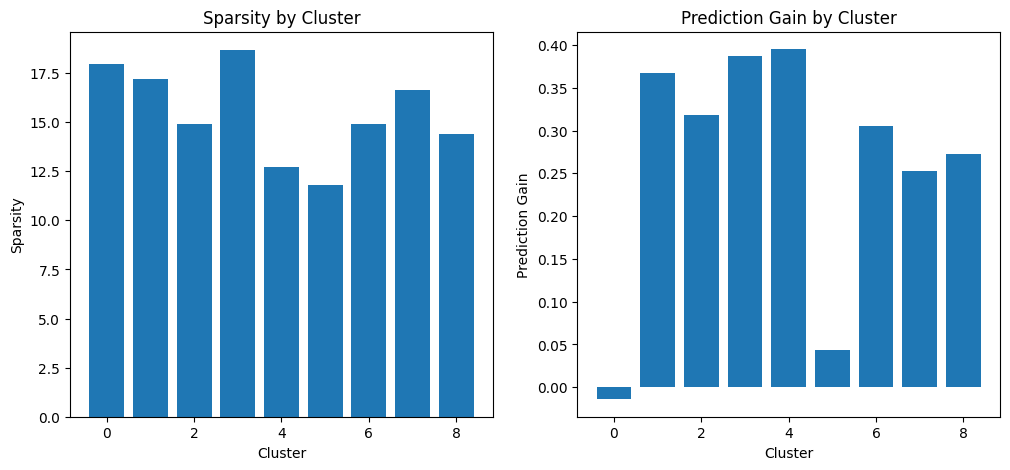

In [17]:
import matplotlib.pyplot as plt

# Prepare containers
cluster_metrics = []
clusters = np.unique(main_cluster_labels)

for cluster_id in clusters:
    # Select test samples belonging to this cluster
    idxs = [i for i, p in enumerate(test_profiles) if p["cluster_id"] == cluster_id]
    if not idxs:
        continue
    X_cluster_test = X_test[idxs]
    cf_cluster = np.array([counterfactuals[i] for i in idxs])
    latencies_cluster = np.array([personalized_latencies[i] for i in idxs])

    metrics = compute_metrics(
        samples=X_cluster_test,
        counterfactuals=cf_cluster,
        latencies=latencies_cluster,
        classifier=classifier,
        autoencoder=autoencoder
    )
    metrics["cluster_id"] = cluster_id
    metrics["size"] = len(idxs)
    cluster_metrics.append(metrics)

# Display as DataFrame
df_metrics = pd.DataFrame(cluster_metrics)
print(df_metrics[["cluster_id", "size", "prediction_gain", "sparsity", "reconstruction_error", "latency"]])

# Plot sparsity and prediction gain per cluster
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].bar(df_metrics["cluster_id"], df_metrics["sparsity"].str.split(" ± ").str[0].astype(float))
axs[0].set_title("Sparsity by Cluster")
axs[0].set_xlabel("Cluster")
axs[0].set_ylabel("Sparsity")

axs[1].bar(df_metrics["cluster_id"], df_metrics["prediction_gain"].str.split(" ± ").str[0].astype(float))
axs[1].set_title("Prediction Gain by Cluster")
axs[1].set_xlabel("Cluster")
axs[1].set_ylabel("Prediction Gain")

plt.show()


In [ ]:
# Step 1: Update cost weights for low-performing clusters
low_perf_clusters = [0, 5]  # example cluster IDs to boost
for profile in cluster_profiles:
    if profile["cluster_id"] in low_perf_clusters:
        profile["cost_weights"]["Credit_Amount"] *= 1.5
        profile["cost_weights"]["Employment"] *= 1.5
        profile["cost_weights"]["Savings"] *= 1.3

# Step 2: Retrain personalized GANs with updated cost weights
for profile in cluster_profiles:
    cluster_id = profile["cluster_id"]
    Xc = cluster_data[cluster_id]["X"]
    yc = cluster_data[cluster_id]["y"]
    
    generator = create_generator(residuals=True)
    discriminator = create_discriminator()
    batches = infinite_data_stream(Xc, yc, batch_size=128)
    
    print(f"Retraining cluster {cluster_id} with updated costs...")
    _ = train_countergan(
        n_discriminator_steps=2,
        n_generator_steps=4,
        n_training_iterations=500,  # lower iterations for quicker fine-tuning
        classifier=classifier,
        discriminator=discriminator,
        generator=generator,
        batches=batches,
        weighted_version=True
    )
    generator.save(f"generators/cluster_{cluster_id}.h5")

# Step 3: Regenerate personalized counterfactuals
counterfactuals = []
personalized_latencies = []
generators = {cid: load_model(f"generators/cluster_{cid}.h5") for cid in range(k_fixed)}

for i, test_sample in enumerate(X_test):
    cluster_id = test_profiles[i]["cluster_id"]
    gen = generators[cluster_id]
    t0 = time.time()
    cf = gen.predict(np.expand_dims(test_sample, axis=0))[0].astype(np.float32)
    personalized_latencies.append(1000 * (time.time() - t0))
    counterfactuals.append(cf)

# Step 4: Re-evaluate personalized counterfactuals
print("\nRe-evaluated Personalized GAN metrics after cost refinement:")
personalized_metrics = compute_metrics(
    samples=X_test,
    counterfactuals=np.array(counterfactuals),
    latencies=np.array(personalized_latencies),
    classifier=classifier,
    autoencoder=autoencoder
)
pprint(personalized_metrics)


Retraining cluster 0 with updated costs...
7/7 [==============================] - 0s 2ms/step
Training iteration 0 at 2025-07-03 17:09:51.304279
7/7 [==============================] - 0s 2ms/step
Autoencoder reconstruction error (infinity to 0): 4.801
Counterfactual prediction gain (0 to 1): 0.029
Sparsity (L1, infinity to 0): 0.210
7/7 [==============================] - 0s 2ms/step
Training iteration 499 at 2025-07-03 17:12:05.461541
7/7 [==============================] - 0s 2ms/step
Autoencoder reconstruction error (infinity to 0): 5.050
Counterfactual prediction gain (0 to 1): -0.106
Sparsity (L1, infinity to 0): 0.398
1/1 [==============================] - 0s 13ms/step
Retraining cluster 1 with updated costs...
7/7 [==============================] - 0s 2ms/step


/home/ahmed/prototype/.venv/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 2ms/step
Training iteration 0 at 2025-07-03 17:12:05.969271
7/7 [==============================] - 0s 2ms/step
Autoencoder reconstruction error (infinity to 0): 4.721
Counterfactual prediction gain (0 to 1): -0.044
Sparsity (L1, infinity to 0): 0.209
7/7 [==============================] - 0s 2ms/step
Training iteration 499 at 2025-07-03 17:14:16.536766
7/7 [==============================] - 0s 2ms/step
Autoencoder reconstruction error (infinity to 0): 4.862
Counterfactual prediction gain (0 to 1): 0.212
Sparsity (L1, infinity to 0): 0.395
1/1 [==============================] - 0s 14ms/step
Retraining cluster 2 with updated costs...
7/7 [==============================] - 0s 2ms/step
Training iteration 0 at 2025-07-03 17:14:17.034000
7/7 [==============================] - 0s 2ms/step
Autoencoder reconstruction error (infinity to 0): 4.777
Counterfactual prediction gain (0 to 1): 0.069
Sparsity (L1, infinity to 0): 0.207
7/7 [=====================

In [18]:
# --- Projection of tightened immutable features per cluster ---
# Define actual feature names in order
feature_names = [
    "Status", "Credit_History", "Purpose_A42", "Job_A173", "Employment",
    "Purpose_A45", "Housing_own", "Job_A172", "Purpose_A48",
    "Other_Debtors_none", "Job_A174", "Purpose_A44",
    "Other_Installment_Plans_stores", "Purpose_A41", "Credit_Amount",
    "Personal_Status_male: single",
    "Property_car or other, not in attribute 6", "Purpose_A43",
    "Existing_Credits", "Purpose_A49", "Month",
    "Other_Installment_Plans_none", "Other_Debtors_guarantor", "Savings",
    "Installment_Rate", "Telephone_yes, registered under the customer's name",
    "Residence_Duration", "Property_real estate", "Foreign_Worker_yes",
    "Personal_Status_male: divorced/separated", "Housing_rent",
    "Property_unknown/no property", "Num_Liable_People", "Age",
    "Purpose_A46", "Purpose_A410", "Personal_Status_male: married/widowed"
]

# Map generic immutable names to actual feature columns
feature_mapping = {
    "Age": ["Age"],
    "Housing": ["Housing_own", "Housing_rent"],
    "Foreign_Worker": ["Foreign_Worker_yes"],
    "Job": [fn for fn in feature_names if fn.startswith("Job_")]
}

# Identify clusters to tweak (below-average prediction gain)
pred_vals = df_metrics["prediction_gain"].str.split(" ± ").str[0].astype(float)
mean_pred = pred_vals.mean()
low_gain_clusters = df_metrics.loc[pred_vals < mean_pred, "cluster_id"].tolist()
print("Clusters below mean gain:", low_gain_clusters)

# Update immutable_features in cluster_profiles
for profile in cluster_profiles:
    if profile["cluster_id"] in low_gain_clusters:
        for feat in ("Housing", "Foreign_Worker"):
            if feat not in profile["immutable_features"]:
                profile["immutable_features"].append(feat)

# Propagate to test_profiles
for tp in test_profiles:
    prof = next(p for p in cluster_profiles if p["cluster_id"] == tp["cluster_id"])
    tp["immutable_features"] = prof["immutable_features"]

# Regenerate and project counterfactuals
counterfactuals_proj = []
latencies_proj = []

for i, x0 in enumerate(X_test):
    cid = test_profiles[i]["cluster_id"]
    imm_feats = test_profiles[i]["immutable_features"]
    gen = generators[cid]

    t0 = time.time()
    cf = gen.predict(np.expand_dims(x0, axis=0))[0].astype(np.float32)
    latencies_proj.append(1000 * (time.time() - t0))

    # Enforce all actual immutable columns
    for feat in imm_feats:
        for actual in feature_mapping.get(feat, [feat]):
            if actual not in feature_names:
                raise ValueError(f"Unknown immutable feature: {actual}")
            idx = feature_names.index(actual)
            cf[idx] = x0[idx]

    counterfactuals_proj.append(cf)

counterfactuals_proj = np.stack(counterfactuals_proj, axis=0)
latencies_arr = np.array(latencies_proj, dtype=np.float32)

# Re-evaluate
print("\nRe-evaluated Personalized GAN (with tightened immutables):")
metrics_tweaked = compute_metrics(
    samples=X_test,
    counterfactuals=counterfactuals_proj,
    latencies=latencies_arr,
    classifier=classifier,
    autoencoder=autoencoder
)
from pprint import pprint
pprint(metrics_tweaked)


Clusters below mean gain: [0, 5, 7]
1/1 [==============================] - 0s 12ms/step

Re-evaluated Personalized GAN (with tightened immutables):
7/7 [==============================] - 0s 2ms/step
{'latency': '40.902 ± 20.029',
 'latency_batch': '8180.395',
 'prediction_gain': '0.269 ± 0.053',
 'reconstruction_error': '4.754 ± 0.254',
 'sparsity': '13.822 ± 0.601'}


In [19]:
import itertools, random, time, pandas as pd, numpy as np
from pprint import pprint

# 1) Define your search space
imm_options = [
    [], 
    ["Housing_own"], 
    ["Foreign_Worker_yes"], 
    ["Housing_own","Foreign_Worker_yes"]
]
cw_grid = [1.0, 1.5, 2.0]
ew_grid = [0.7, 1.0, 1.5]
sw_grid = [0.8, 1.0, 1.5]
jw_grid = [0.6, 1.0, 1.5]

# 2) Build all combinations, then subsample
all_combos = list(itertools.product(imm_options, cw_grid, ew_grid, sw_grid, jw_grid))
random.seed(42)
sampled_combos = random.sample(all_combos, k=30)   # only 30 random settings

# 3) Only tune the worst clusters
to_tune = low_gain_clusters  # e.g. [0,1,5,7]

records = []
for cid in to_tune:
    # Pre-split train/test for this cluster
    train_idxs = [i for i,lbl in enumerate(main_cluster_labels) if lbl==cid]
    test_idxs  = [i for i,tp in enumerate(test_profiles) if tp["cluster_id"]==cid]
    Xc_train, yc_train = X_train[train_idxs], y_train[train_idxs]
    Xc_test  = X_test[test_idxs]
    
    for imm_feats, cw, ew, sw, jw in sampled_combos:
        # 3a) Build temporary profile
        tmp_prof = {"cluster_id":cid,
                    "immutable_features": imm_feats,
                    "cost_weights":{
                        "Credit_Amount":cw,
                        "Employment":ew,
                        "Savings":sw,
                        "Job":jw
                    }}

        # 3b) Train for fewer iterations
        gen = create_generator(residuals=True)
        disc = create_discriminator()
        batches = infinite_data_stream(Xc_train, yc_train, batch_size=128)
        t0 = time.time()
        train_countergan(
            n_discriminator_steps=2,
            n_generator_steps=4,
            n_training_iterations=100,   # cut down
            classifier=classifier,
            discriminator=disc,
            generator=gen,
            batches=batches,
            weighted_version=True
        )
        train_time = time.time() - t0

        # 3c) Generate & project
        cfs = []
        for x0 in Xc_test:
            cf = gen.predict(np.expand_dims(x0,axis=0))[0].astype(np.float32)
            for feat in imm_feats:
                idx = feature_names.index(feat)
                cf[idx] = x0[idx]
            cfs.append(cf)
        cfs = np.stack(cfs, axis=0)

        # 3d) Evaluate
        metrics = compute_metrics(
            samples=Xc_test,
            counterfactuals=cfs,
            latencies = np.zeros(len(Xc_test), dtype=np.float32),
            classifier=classifier,
            autoencoder=autoencoder
        )
        gain = float(metrics["prediction_gain"].split(" ± ")[0])
        spars = float(metrics["sparsity"].split(" ± ")[0])

        # 3e) Record
        records.append({
            "cluster_id": cid,
            "imm_feats": "/".join(imm_feats) or "none",
            "CW": cw, "EW": ew, "SW": sw, "JW": jw,
            "gain": gain, "sparsity": spars, "time_s": train_time
        })
        print(f"[C{cid}] imm={imm_feats} CW={cw} EW={ew} SW={sw} JW={jw} → gain={gain:.3f}, spars={spars:.3f}")

# 4) Summarize top results
df_grid = pd.DataFrame(records)
# pick top 3 by gain + sparsity for each cluster
best = (df_grid.assign(score=lambda d: d.gain + d.sparsity/100)
              .sort_values(["cluster_id","score"], ascending=[True,False])
              .groupby("cluster_id").head(3))
display(best)


7/7 [==============================] - 0s 2ms/step
Training iteration 0 at 2025-07-03 20:29:50.502472
7/7 [==============================] - 0s 2ms/step
Autoencoder reconstruction error (infinity to 0): 4.646
Counterfactual prediction gain (0 to 1): 0.037
Sparsity (L1, infinity to 0): 0.214
7/7 [==============================] - 0s 1ms/step
Training iteration 99 at 2025-07-03 20:30:17.563300
7/7 [==============================] - 0s 1ms/step
Autoencoder reconstruction error (infinity to 0): 5.056
Counterfactual prediction gain (0 to 1): 0.102
Sparsity (L1, infinity to 0): 0.346
1/1 [==============================] - 0s 15ms/step
[C0] imm=[] CW=2.0 EW=0.7 SW=1.0 JW=0.6 → gain=0.038, spars=12.694
7/7 [==============================] - 0s 2ms/step
Training iteration 0 at 2025-07-03 20:30:18.980307
7/7 [==============================] - 0s 2ms/step
Autoencoder reconstruction error (infinity to 0): 4.808
Counterfactual prediction gain (0 to 1): 0.171
Sparsity (L1, infinity to 0): 0.223
7/7 

cluster_id                       imm_feats   CW   EW   SW   JW   gain  \
1            0                            none  1.0  1.0  1.0  0.6  0.235   
3            0                     Housing_own  1.5  1.0  1.5  1.5  0.157   
21           0              Foreign_Worker_yes  1.5  1.5  1.5  1.0  0.167   
32           5                     Housing_own  2.0  0.7  1.0  1.5  0.259   
47           5  Housing_own/Foreign_Worker_yes  2.0  1.0  0.8  1.5  0.217   
34           5                     Housing_own  1.5  0.7  1.5  0.6  0.262   
73           7                            none  1.5  1.5  0.8  1.5  0.333   
76           7  Housing_own/Foreign_Worker_yes  1.0  1.0  1.5  0.6  0.301   
65           7                            none  2.0  1.0  1.5  1.5  0.305   

    sparsity     time_s    score  
1     14.115  24.281578  0.37615  
3     14.062  27.627021  0.29762  
21    12.802  29.762233  0.29502  
32    17.930  26.997362  0.43830  
47    21.898  27.455303  0.43598  
34    16.355  26.692653  0.42555  
73    18.373  29.207483  0.51673  
76    19.524  33.031242  0.49624  
65    18.933  30.483405  0.49433